In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jan711","key":"b20770c27dcf64ccce3be72033057bce"}'}

In [ ]:
!pip install kagglehub


In [ ]:
import kagglehub

# Download the latest version of the dataset
path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)


100%|██████████| 964M/964M [00:10<00:00, 94.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/moltean/fruits/versions/11


In [ ]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Build up the pretrained transformers model
from transformers import ViTFeatureExtractor, ViTModel

# Plot tool
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 256
latent_dim = 256
epochs = 3
learning_rate = 1e-4

print(device)

cuda


In [ ]:
# Add the transformation of image
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])

training_path = "/root/.cache/kagglehub/datasets/moltean/fruits/versions/11/fruits-360_dataset_100x100/fruits-360/Training"
validating_path = "/root/.cache/kagglehub/datasets/moltean/fruits/versions/11/fruits-360_dataset_100x100/fruits-360/Test"



In [ ]:
# Create train, val dataset
training_dataset = ImageFolder(training_path,
                               transform=data_transforms)
validating_dataset = ImageFolder(validating_path,
                                 transform=data_transforms)

# Create train, val dataloader
training_dataloader = DataLoader(training_dataset,
                                 batch_size=batch_size,
                                 shuffle=True)
val_dataloader = DataLoader(validating_dataset, batch_size=batch_size, shuffle=False)


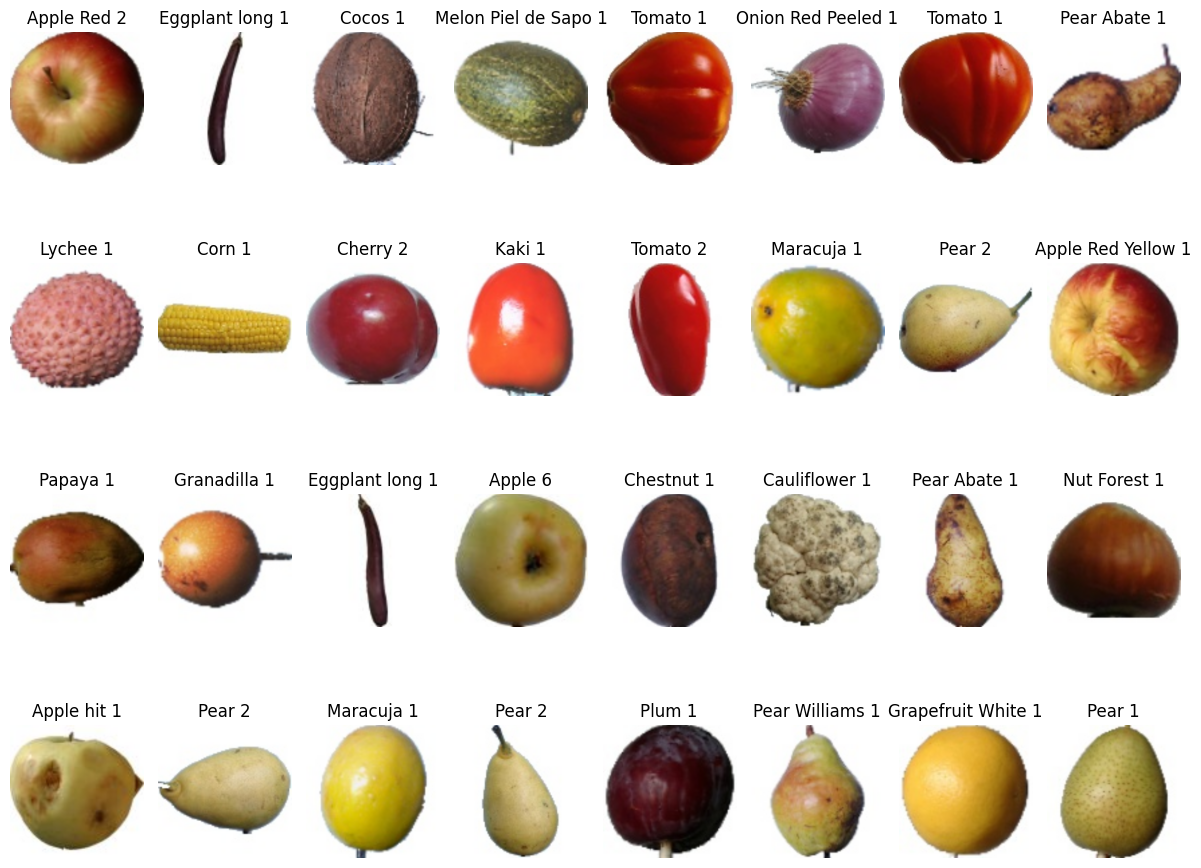

In [ ]:
image_size = 32

# Get the image from dataloader
show_images, show_labels = next(iter(training_dataloader))
show_images = show_images[:image_size]
show_labels = show_labels[:image_size]

ncols = 8
nrows = int(image_size / ncols) + 1

# Set up the figure size
plt.figure(figsize=(12, 12))


def inverse_normalized(image):
    # Clamp the value to (0.0, 1.0) for floats
    image = torch.clamp(input=image * 0.5 + 0.5,
                        min=0.0,
                        max=1.0)
    return image


for idx in range(len(show_images)):
    # Set up the subplot
    plt.subplot(nrows, ncols, idx + 1)

    # Close the axis and plot the image
    plt.axis("off")
    # Note that the label is change into integer, we should change it back to category
    plt.title(training_dataset.classes[show_labels[idx].item()])
    # Note that the image channel of tensor is: (channel, width, height)
    # We need to change it to (width, height, channel) which we use permute to realize it
    plt.imshow(inverse_normalized(show_images[idx].permute(1, 2, 0)))

# Avoid overlapping of different titles
plt.tight_layout()


In [ ]:
class CategoryClass(nn.Module):
    def __init__(self, vit, latent_dim, classes_):
        super(CategoryClass, self).__init__()

        self.classes_ = classes_

        # Set up model architecture
        self.vit = vit
        self.fc_1 = nn.Linear(768, latent_dim)
        self.fc_out = nn.Linear(latent_dim, self.classes_)
        self.dropout = nn.Dropout(0.2)

    def forward(self, in_data):
        # Type of output `BaseModelOutputWithPooling`
        vit_outputs = self.vit(in_data)

        # Shape of pooler_output: (batch_size, hidden_size)
        pooler_output = vit_outputs.pooler_output

        # Pass through the linear layout to predict the class
        # Shape of output: (batch_size, classes_)
        outputs = torch.relu(self.fc_1(pooler_output))
        outputs = self.fc_out(self.dropout(outputs))

        return outputs

In [ ]:
# Set up the pretrained model
vit = ViTModel.from_pretrained('google/vit-base-patch16-224')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Freeze the layers in vit exclude the pooler layers
for param in vit.parameters():
    param.requires_grad = False

vit.pooler.dense.weight.requires_grad = True
vit.pooler.dense.bias.requires_grad = True

In [ ]:
# Create the complete model
model = CategoryClass(vit,
                      latent_dim,
                      len(training_dataset.classes)).to(device)

In [ ]:
# Set up loss function and optimizers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), learning_rate)

In [ ]:
# Save the training and validating information
training_loss_history =[]
training_accuracy_history = []
validating_loss_history = []
validating_accuracy_history = []

# We only train one epoch
#  Therefore, we save the batch information
batch_loss_history = []
batch_accuracy_history = []

for epoch in range(epochs):
    # Set to the train mode
    model.train()

    train_epoch_loss = 0.0
    train_epoch_accuracy = 0.0
    for idx, (images, labels) in enumerate(training_dataloader):
        # Move the data to the device
        images = images.to(device)
        labels = labels.to(device)

        # Pass through the model
        outputs = model(images)
         # Count the loss and update the parameters
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record the training information
        train_epoch_loss += loss.item()
        predict_class = outputs.argmax(dim=-1)
        accuracy = torch.sum(predict_class == labels).item() / labels.shape[0]
        train_epoch_accuracy += accuracy

        # Save the batch information
        batch_loss_history.append(loss.item())
        batch_accuracy_history.append(accuracy)

        # Print batch information
        print(f"Batch {idx + 1} in epoch {epoch + 1}/{epochs}")
        print(f"Average loss: {loss.item()}")
        print(f"Average accuracy {accuracy}")

    # Set to the eval mode
    model.eval()
    val_epoch_loss = 0.0
    val_epoch_accuracy = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_dataloader:
            # Move data to the device
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            # Pass through model
            val_outputs = model(val_images)

            # Count the loss and accuracy

            val_epoch_loss += criterion(val_outputs, val_labels).item()
            val_predict_class = val_outputs.argmax(dim=-1)
            val_epoch_accuracy += torch.sum(val_predict_class == val_labels).item() / val_labels.shape[0]

    # Save the epoch information
    training_loss_history.append(train_epoch_loss / len(training_dataloader))
    training_accuracy_history.append(train_epoch_accuracy / len(training_dataloader))
    validating_loss_history.append(val_epoch_loss / len(val_dataloader))
    validating_accuracy_history.append(val_epoch_accuracy / len(val_dataloader))

    # Print the information
    print(f"Epoch {epoch + 1}")
    print(f"Average training loss: {training_loss_history[-1]}, Average validation loss: {validating_loss_history[-1]}")
    print(f"Average training accuracy: {training_accuracy_history[-1]}, Average validation accuracy: {validating_accuracy_history[-1]}")


Batch 1 in epoch 1/3
Average loss: 4.956547260284424
Average accuracy 0.0
Batch 2 in epoch 1/3
Average loss: 4.952175617218018
Average accuracy 0.01171875
Batch 3 in epoch 1/3
Average loss: 4.9420857429504395
Average accuracy 0.00390625
Batch 4 in epoch 1/3
Average loss: 4.913959503173828
Average accuracy 0.01171875
Batch 5 in epoch 1/3
Average loss: 4.890295028686523
Average accuracy 0.03515625
Batch 6 in epoch 1/3
Average loss: 4.870438098907471
Average accuracy 0.03125
Batch 7 in epoch 1/3
Average loss: 4.855959415435791
Average accuracy 0.08203125
Batch 8 in epoch 1/3
Average loss: 4.835366249084473
Average accuracy 0.06640625
Batch 9 in epoch 1/3
Average loss: 4.8318328857421875
Average accuracy 0.078125
Batch 10 in epoch 1/3
Average loss: 4.8176422119140625
Average accuracy 0.10546875
Batch 11 in epoch 1/3
Average loss: 4.771707057952881
Average accuracy 0.12109375
Batch 12 in epoch 1/3
Average loss: 4.750863552093506
Average accuracy 0.16796875
Batch 13 in epoch 1/3
Average loss

In [ ]:
# Save the model weight
torch.save(model.state_dict(), "model.pt")

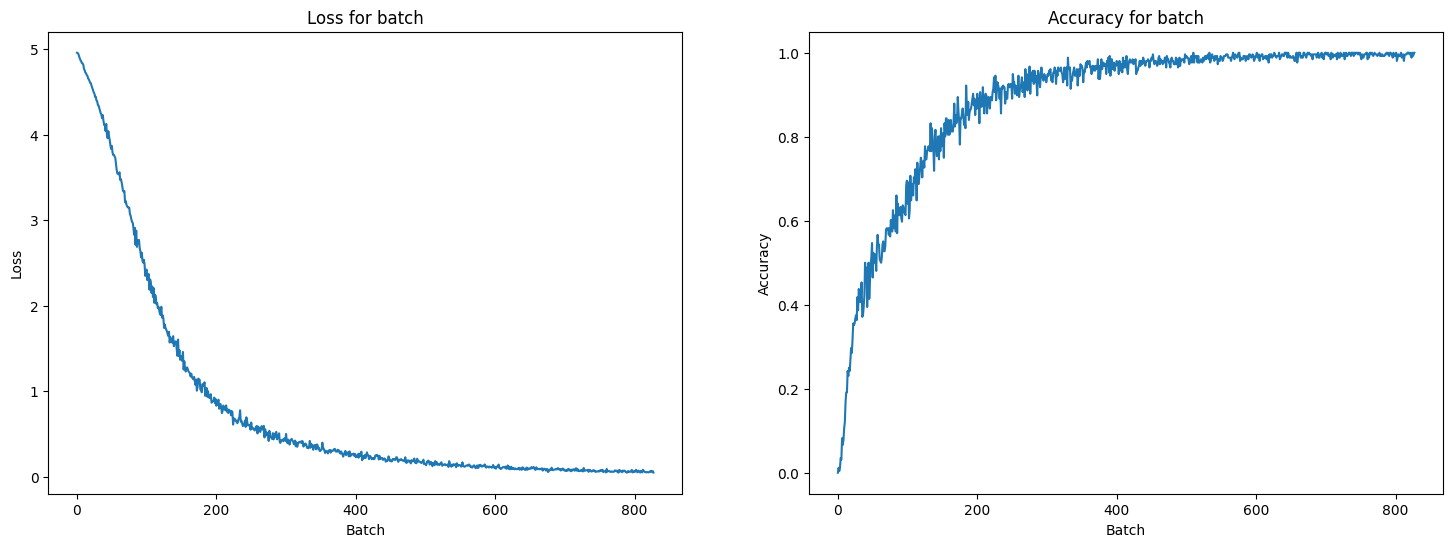

In [ ]:
# Plot the loss and accuracy
plt.figure(figsize=(18,6))

# Loss
plt.subplot(1, 2, 1)
plt.title("Loss for batch")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(batch_loss_history)

# Accuracy
plt.subplot(1, 2, 2)
plt.title("Accuracy for batch")
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.plot(batch_accuracy_history)

In [ ]:
prediction = []
true_labels = []

# Create the classification report on test dataset
with torch.no_grad():
    for val_images, val_labels in val_dataloader:
        # Move data to the device
        val_images = val_images.to(device)
        val_labels = val_labels.to(device)

        # Pass through model
        val_outputs = model(val_images)

        # Count the loss and accuracy
        val_predict_class = val_outputs.argmax(dim=-1)

        prediction.extend([predict_class.item() for predict_class in val_predict_class])
        true_labels.extend([val_label.item() for val_label in val_labels])

In [ ]:
import pandas as pd

# Output dict for making the report
report = classification_report(true_labels, prediction,
                               output_dict=True,
                               target_names=training_dataset.classes)
report_df = pd.DataFrame(report).transpose()

In [ ]:
# Show all columns
pd.set_option("display.max_rows", None)
report_df.head(134)

,precision,recall,f1-score,support
Apple 6,1.000000,1.000000,1.000000,157.0
Apple Braeburn 1,0.911111,1.000000,0.953488,164.0
Apple Crimson Snow 1,0.990385,0.695946,0.817460,148.0
Apple Golden 1,1.000000,1.000000,1.000000,160.0
Apple Golden 2,1.000000,0.993902,0.996942,164.0
Apple Golden 3,0.920000,1.000000,0.958333,161.0
Apple Granny Smith 1,1.000000,1.000000,1.000000,164.0
Apple Pink Lady 1,0.767677,1.000000,0.868571,152.0
Apple Red 1,0.960784,0.896341,0.927445,164.0
Apple Red 2,1.000000,1.000000,1.000000,164.0
